**Author:** Soham Bopardikar  
**Advisor:** Hanrui Wang

# Superdense Coding
Superdense coding is a quantum communication protocol that allows the transmission of two classical bits of information using only one qubit`[1]`. It takes advantage of quantum entanglement and the ability to manipulate qubits in superposition. Charles H. Bennett and Stephen Wiesner proposed this technique in 1970(though it was not published until 1992 `[2]`) and it was experimentally realised in 1996 by Klaus Mattle, Harald Weinfurter, Paul G. Kwiat, and Anton Zeilinger utilising entangled photon pairs.

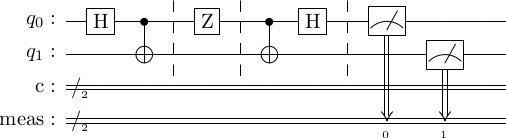

In this tutorial, we will learn how to implement superdense coding using the `torchquantum` library. We will cover the following steps:-

### **Step 1 - Preparing the entangled state/ 2 qubit bell pair.**

First, a bell pair of two qubits is created. Where q0 represents the sender's qubit and q1 represents the receiver's qubit. A hadamard gate is used to place q0 in a superposition of states. Then, with q0 as the control and q1 as the target, a CNOT operation is conducted.

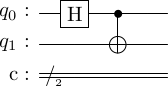


### **Step 2 - Encoding the message**

Rules:


a) For sending 00 - Perform no operation. 

b) For sending 01 - Perform a Pauli-Z operation where q1s state is flipped.

c) For sending 10 - Apply a Pauli-X gate. 

d) For sending 11 - Apply a Pauli-Z gate followed by a Pauli-X gate.

### **Step 3 - Decoding the message**

Bob gets Alice's qubit (leftmost qubit) and decodes the message sent. He does not need to know the state to decode it; instead, he simply applies the restoration operation. Bob employs a CNOT gate, with the leftmost qubit serving as control and the rightmost serving as target. Then he uses a Hadamard gate and eventually measures both qubits to extract the sent message.


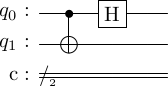


### **Step 4 - Measurement**

In superdense coding, measurement plays a crucial role in extracting the classical bits that Alice encoded. After Bob has applied the decoding gates, he performs a measurement on both qubits to extract the information.


## Installation

In [ ]:
!git clone https://github.com/mit-han-lab/torchquantum.git

Cloning into 'torchquantum'...
remote: Enumerating objects: 12494, done.
remote: Counting objects: 100% (765/765), done.
remote: Compressing objects: 100% (345/345), done.
remote: Total 12494 (delta 423), reused 674 (delta 392), pack-reused 11729
Receiving objects: 100% (12494/12494), 74.92 MiB | 31.26 MiB/s, done.
Resolving deltas: 100% (6780/6780), done.


In [ ]:
%cd torchquantum

/content/torchquantum


In [ ]:
!pip install --editable .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/torchquantum
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
%env PYTHONPATH=.

env: PYTHONPATH=.


## Importing modules




In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torchquantum as tq
import torchquantum.functional as tqf
import argparse
import tqdm
import time

##Step 1: Preparing the 2-qubit bell pair

To prepare an entangled state, we use the Hadamard gate (h) and the CNOT gate (cx). The Hadamard gate (h) is applied to the first qubit (qubit 0) to put it 
into a superposition of |0⟩ and |1⟩. This creates an entangled state between the two qubits. The controlled-X gate (cx) is applied with the first qubit as the control and the second qubit as the target. It entangles the qubits further and prepares them for superdense coding. Let's wrap this all up in a function.


In [ ]:
def bell_pair():
  qdev = tq.QuantumDevice(n_wires=2, bsz=1, device="cpu")
  qdev.h(wires=0)
  qdev.cnot(wires=[0, 1])
  return qdev

## Step 2: Encoding the message
Here, we develop a function to encrypt any message with classical bits 00, 01, 10 and 11 that Alice wishes to transmit over the channel.

In [ ]:
def encode_message(qdev, qubit, msg):
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid")
    if msg[1] == "1":
        qdev.x(wires=qubit)
    if msg[0] == "1":
        qdev.z(wires=qubit)
    return qdev

## Step 3 - Decoding the message
Once Alice has encoded her message, she sends her qubit to Bob. Bob can then decode the message by applying the corresponding gates to his qubit. Bob applies a controlled-X gate (cx) with the first qubit as the control and the second qubit as the target. This operation "transfers" the encoded message from Alice's qubit to Bob's qubit. Then, Bob applies a Hadamard gate (h) to the first qubit. This allows Bob to extract the original classical bits.

In [ ]:
def decode_message(qdev):
    qdev.cx(wires=[0, 1])
    qdev.h(wires=0)
    return qdev

Putting all these functions together

In [ ]:
qdev = bell_pair() # Creating the entangled pair between Alice and Bob

message = '10'
qdev = encode_message(qdev, 1, message) # Encoding the message at Alice's end

qdev = decode_message(qdev) # Decoding the original message at Bob's end

## Step 4 - Measurement 
Finally, Bob can measure the qubits to extract the encoded message. The `tq.measure` function in `torchquantum` is used to measure the qubits. This collapses the qubits into classical states, and the measurement results give us the original message bits '10' sent by Alice with a probability of 100%.

In [ ]:
print(tq.measure(qdev, n_shots=1024)) # Finally, Bob measures his qubits to read Alice's message

[OrderedDict([('00', 0), ('01', 0), ('10', 1024), ('11', 0)])]


The `tq.measure function` in `torchquantum` is used to measure the qubits. This collapses the qubits into classical states, and the measurement results give us the original message bits '10' sent by Alice with a probability of 100%.

## References:

[1] Bennett, C.H., Brassard, G., Crépeau, C., Jozsa, R., Peres, A. and Wootters, W.K., 1993. Teleporting an unknown quantum state via dual classical and Einstein-Podolsky-Rosen channels. Physical review letters, 70(13), p.1895.

[2] Bennett, C.H. and Wiesner, S.J., 1992. Communication via one-and two-particle operators on Einstein-Podolsky-Rosen states. Physical review letters, 69(20), p.2881.

[3] [Superdense Coding - Qiskit](https://learn.qiskit.org/course/ch-algorithms/superdense-coding) 

[4] [Superdense coding - Wikipedia](https://en.wikipedia.org/wiki/Superdense_coding#:~:text=This%20protocol%20was%20first%20proposed,Zeilinger%20using%20entangled%20photon%20pairs.)